<a href="https://colab.research.google.com/github/Chelsea-hzc/Poetry_Analyisis/blob/master/Music_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Music Analysis: Audio features and Lyrics
By Derek Bowdle, Chelsea Chen, Amanda Ho, and Minghan Xu

# Introduction
For this project, we decided to analyze music data. Music is a unique medium for ideas because of how both widely expressive it can be and they way it reaches out to people on a global scale. By studying the audio features of a variety of songs in conjunction with their lyrics, we aim to get more insight into the relationship of themes and fashion of music. Even without a closer look into lyrics and their relation to genre, one would have expectations about genres including genres of music one does would usually not listen to. We found that yes, some intuitions one would have about music follows, but learning the nuances of musical aspects can be just as fulfilling as confirmation of prejudices. Music inspires an array of people, so there are many different styles of music singing different things, but through this project, we are also reminded these different people are also sometimes passioned enough to express the same things because on a fundamental level we also often share the same experiences.

Our goal is to explore relations between genres and song properties, including both acoustic features and lyrics. To do this, we used two datasets. The first one includes a numerical measure of acoustic features of [Spotify song tracks](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). The second is the [MetroLyrics](https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics) dataset providing lyrics of a variety of songs. Here is the link to the [UCSB box](https://ucsb.box.com/s/a07og5ssz578xxi6r63h69l1pfmq4xu1) that contains our datasets.

First, we cleaned the data and merged the two datasets into one main data frame that contains 13 audio features and lyrics for each song. We used this data frame called “data” for our analysis. Then we performed exploratory analysis on the acoustic features, involving correlations over univariate and bivariate distribution. In the second part, we preprocessed the lyrics data and used TF-IDF model and non-negative matrix factorization (NMF) to extract topics out of them. We examined whether genres are distinguished by these topics of lyrics. In the end, we tried to find out potential relations between acoustic features and lyrics.





#Music Data

### Importing Data Sets

In [ ]:
import pandas as pd
import numpy as np
import io

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
###from google.colab import files

from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#reading datasets
acoustic_feat_read = pd.read_csv('gdrive/My Drive/Colab Notebooks/Music Analysis/acoustic_features.csv') 
popularity_read = pd.read_csv('gdrive/My Drive/Colab Notebooks/Music Analysis/popularity.csv')
reviews_read = pd.read_csv('gdrive/My Drive/Colab Notebooks/Music Analysis/reviews.csv')
lyrics_read = pd.read_csv('gdrive/My Drive/Colab Notebooks/Music Analysis/lyrics.csv')

### Cleaning Data
In the process of creating the final dataset used for analysis, we first go through the raw dataset to remove unessessary values such as spotify specific id's, redundant indexes, and songs with little or no lyrics. Since the datasets do not share the same labeling methods for song titles, we also rename the song and artist columns by making the string values all lowercase seperated by a single whitespace. Because not all songs are present in both the lyrics and acoustic features dataset, we aggregate together the songs shared in each dataframe here afterwards to create the final dataframe.

In [ ]:
acoustic_feat_read.head(3)

index                      id  ...                album_id        date
0      0  0Veyvc3n9AcLSoK3r1dA12  ...  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21
1      1  77JzXZonNumWsuXKy9vr3U  ...  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21
2      2  18yllZD0TdF7ykcREib8Z1  ...  3r5hf3Cj3EMh1C2saQ8jyt  2018-12-21

[3 rows x 20 columns]

In [ ]:
#cleaning not needed columns in acoustic features
acoustic_feat = acoustic_feat_read.drop(columns=['id', 'album_id'])
#lower case song, artist as to match the song, artist columns in other dataframes
acoustic_feat['song'] = acoustic_feat['song'].str.lower()
acoustic_feat['artist'] = acoustic_feat['artist'].str.lower()
#indexing by album, artist
acoustic_feat.set_index(['album', 'artist'], inplace = True)
acoustic_feat.head(3)

index  ...        date
album      artist                         ...            
Hoodie SZN a boogie wit da hoodie      0  ...  2018-12-21
           a boogie wit da hoodie      1  ...  2018-12-21
           a boogie wit da hoodie      2  ...  2018-12-21

[3 rows x 16 columns]

In [ ]:
lyrics_read.head(3)

index          song  ...  genre                                             lyrics
0      0     ego-remix  ...    Pop  Oh baby, how you doing?\nYou know I'm gonna cu...
1      1  then-tell-me  ...    Pop  playin' everything so easy,\nit's like you see...
2      2       honesty  ...    Pop  If you search\nFor tenderness\nIt isn't hard t...

[3 rows x 6 columns]

In [ ]:
#using regex to take out '-' in song, artist data 
lyrics = lyrics_read.drop(['genre', 'year', 'index'], axis = 1)
lyrics.set_index(['song', 'artist'])
lyrics['artist'] = lyrics['artist'].replace(r'-', ' ', regex=True)
lyrics['song'] = lyrics['song'].replace(r'-', ' ', regex=True)
lyrics.head(3)

song  ...                                             lyrics
0     ego remix  ...  Oh baby, how you doing?\nYou know I'm gonna cu...
1  then tell me  ...  playin' everything so easy,\nit's like you see...
2       honesty  ...  If you search\nFor tenderness\nIt isn't hard t...

[3 rows x 3 columns]

In [ ]:
#giving reviews the same treatment
reviews = reviews_read.drop(['index','id','role'], axis=1)
reviews['artist'] = reviews['artist'].str.lower()
reviews.set_index(['album', 'artist'], inplace=True)
reviews.head(3)

genre  ...                                               link
album                                      artist                   ...                                                   
“…The Best Live Show of All Time” — NME EP david byrne        Rock  ...  https://pitchfork.com/reviews/albums/david-byr...
Lost Lovesongs / Lostsongs Vol. 2          dj healer    Electronic  ...  https://pitchfork.com/reviews/albums/dj-healer...
Roman Birds                                jorge velez  Electronic  ...  https://pitchfork.com/reviews/albums/jorge-vel...

[3 rows x 7 columns]

In [ ]:
#joining reviews to acoustic_feat on album, artist to make dataframe 'data'
data = acoustic_feat.reset_index().join(reviews[['genre', 'score']], on=['album', 'artist']).set_index(['album', 'artist']).dropna()
#merging lyrics to artist, song to data
data = data.merge(lyrics, how='right', on=['artist', 'song']).dropna()
print(len(data))
data

3937


artist  ...                                             lyrics
0         eminem  ...  WHOOOO!!!\nHey, how you guys doin.\nYou want m...
1         eminem  ...  Ah ah ah ahhh (Oh god damn)(Ooh)\nI'm gonna fa...
2         eminem  ...  Whatever\nDre just let it run\nEy yo turn the ...
3         eminem  ...  Whatever\nDre just let it run\nEy yo turn the ...
4         eminem  ...  Hi! My name is (what?)\nMy name is (who?)\nMy ...
...          ...  ...                                                ...
4338  blue cheer  ...  Whew, whoa alright!\nI just wanna say I love y...
4339  blue cheer  ...  Help me please, Doctor\nDoctor, won't you plea...
4340  blue cheer  ...  Alright!\nA cold, cold darkness\nAnd past conf...
4341  blue cheer  ...  I been sitting over here on Parchment Farm\nI ...
4342  blue cheer  ...  Listen here baby\n'Cause you outta time\nI'm s...

[3937 rows x 20 columns]

In [ ]:
data[data.lyrics.apply(lambda x: len(str(x)) < 70)].lyrics.unique()

array(['They look like twins\nThat was embarrassing', 'instrumental',
       'All of which makes me anxious\nAt times unbearably so',
       '[Instrumental]', '(instrumental)', 'INSTRUMENTAL',
       "I've done it\nI'm drifting into a world\nof limitless dimensions",
       'Aerodynamics\nAerodynamics\nAerodynamics\n...', 'instumental',
       '*instrumental*', '*instrumental *', '(Instrumental)',
       'Instrumental\nNo Lyrics',
       'Now the world,\nit seems to care about...',
       '{Stop the music and go home\nI repeat\nStop the music and go home}',
       'Phoenix\nPhoenix\nPhoenix\n...', 'instru mental',
       '[instrumental track]\n[instrumental track]\n[instrumental track]',
       'there are no lyrics to "Team"; it is a purely instrumental song.',
       "there aren't any lyrics, this song is simply instrumental",
       'Whaaaa\nOooh x2\nAaah Oooh\nOooh x2\nAaah Oooh\nOooh Ahooh\nOooh Ahooh',
       'Sun\nSun\nSun\nSun\nSun\nSun\nSun\nSun\nSun',
       'Woman\nWoman\nMak

The features of interest have been put together into one dataframe, now we remove songs that have little or no lyrics.

In [ ]:
data = data[data.lyrics.apply(lambda x: len(str(x)) > 70)]

In [ ]:
# check duplicated lyrics
data[data.duplicated(['lyrics'])]

artist  ...                                             lyrics
3         eminem  ...  Whatever\nDre just let it run\nEy yo turn the ...
6         eminem  ...  My tea's gone cold I'm wondering why I\nGot ou...
7         eminem  ...  My tea's gone cold I'm wondering why I\nGot ou...
10        eminem  ...  These ideas are nightmares to white parents\nW...
12        eminem  ...  Obie Trice.\nReal name no gimmicks\nTwo traile...
...          ...  ...                                                ...
4165  atmosphere  ...  I do believe in monsters, I call them officers...
4167  atmosphere  ...  She abandoned me left out in the cold\nNo supr...
4169  atmosphere  ...  [Slug]\n1, 2, 3, 4, 5, 6, 7\nGod loves you (x1...
4171  atmosphere  ...  Pain [3x]\nThe way she listen to what the mc s...
4173  atmosphere  ...  [Slug]\nShrapnel...\nI can't remember who aske...

[69 rows x 20 columns]

In [ ]:
# delete duplicates
data.drop_duplicates('lyrics',keep='first',inplace=True)
len(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


3772

In [ ]:
data.isnull().sum() # check null values in each column

artist              0
index               0
song                0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
date                0
genre               0
score               0
lyrics              0
dtype: int64

# Acoustic Features Exploratory Analysis


###A first look at acoustic features, starting with univariate distributions.

In [ ]:
feature_data = data[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 
                 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'genre']]

feature_data = feature_data.set_index('genre')
feature_data

acousticness  danceability  ...  time_signature  valence
genre                                   ...                         
Rap              0.14000         0.374  ...             5.0    0.146
Rap              0.00629         0.840  ...             4.0    0.346
Rap              0.13700         0.810  ...             4.0    0.323
Rap              0.04110         0.860  ...             4.0    0.833
Rap              0.03780         0.779  ...             4.0    0.533
...                  ...           ...  ...             ...      ...
Metal,Rock       0.03590         0.473  ...             1.0    0.486
Metal,Rock       0.19800         0.280  ...             4.0    0.267
Metal,Rock       0.16100         0.435  ...             4.0    0.692
Metal,Rock       0.11800         0.316  ...             4.0    0.558
Metal,Rock       0.28900         0.385  ...             4.0    0.351

[3772 rows x 13 columns]

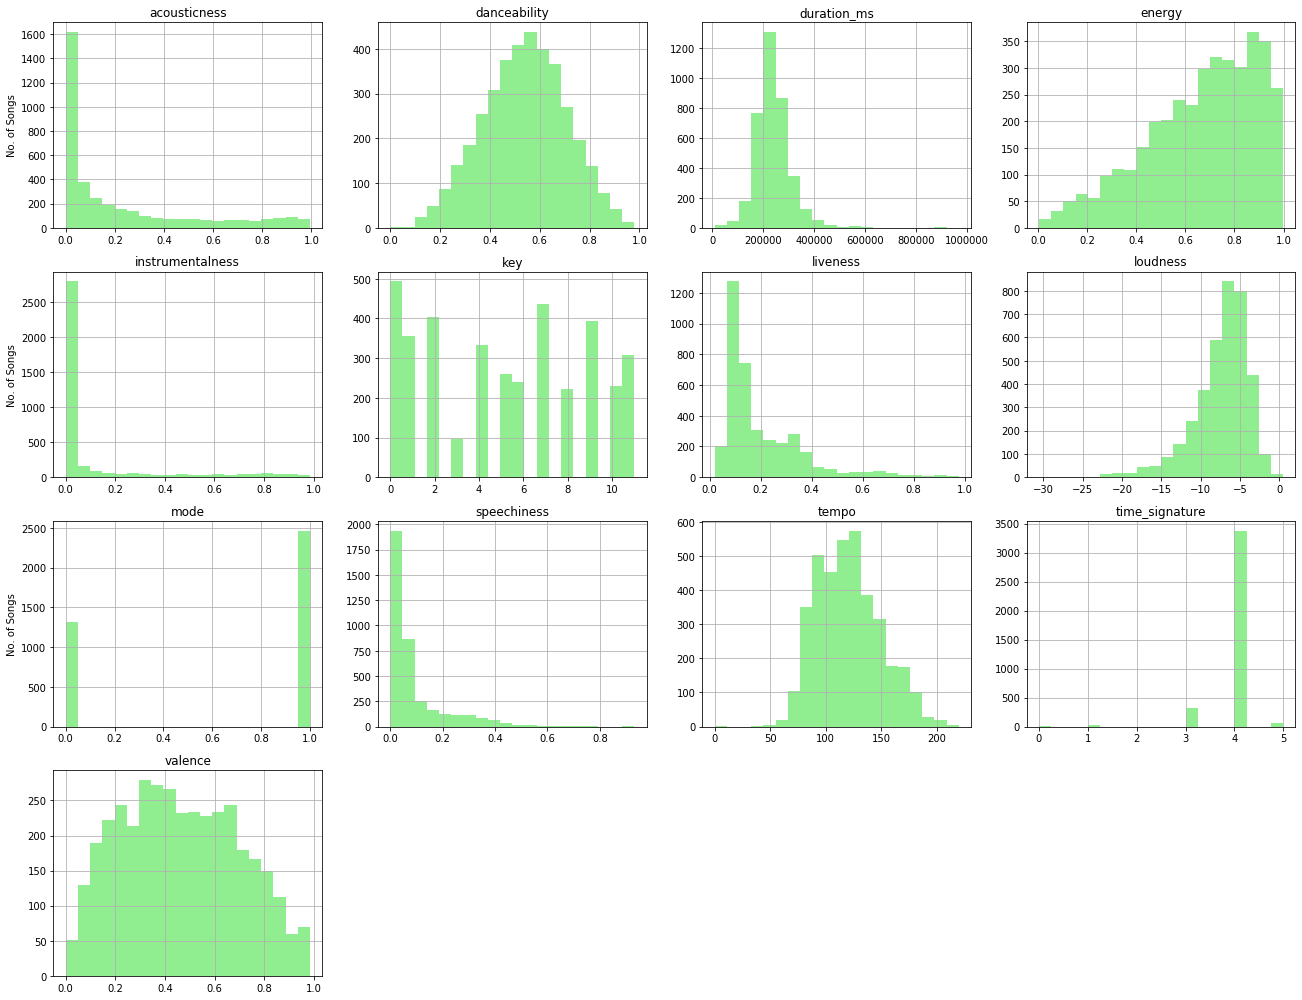

In [ ]:
axes = feature_data.hist(figsize=(18,14), bins=20, alpha=1, color='lightgreen');

axes = axes.ravel()
plt.tight_layout()

features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 
          'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']

for i in range(len(features)-1):
    axes[i].set_title(features[i])
    if i % 4 == 0:
        axes[i].set_ylabel('No. of Songs')

Text(0.5, 0.98, 'Features Correlation Heatmap')

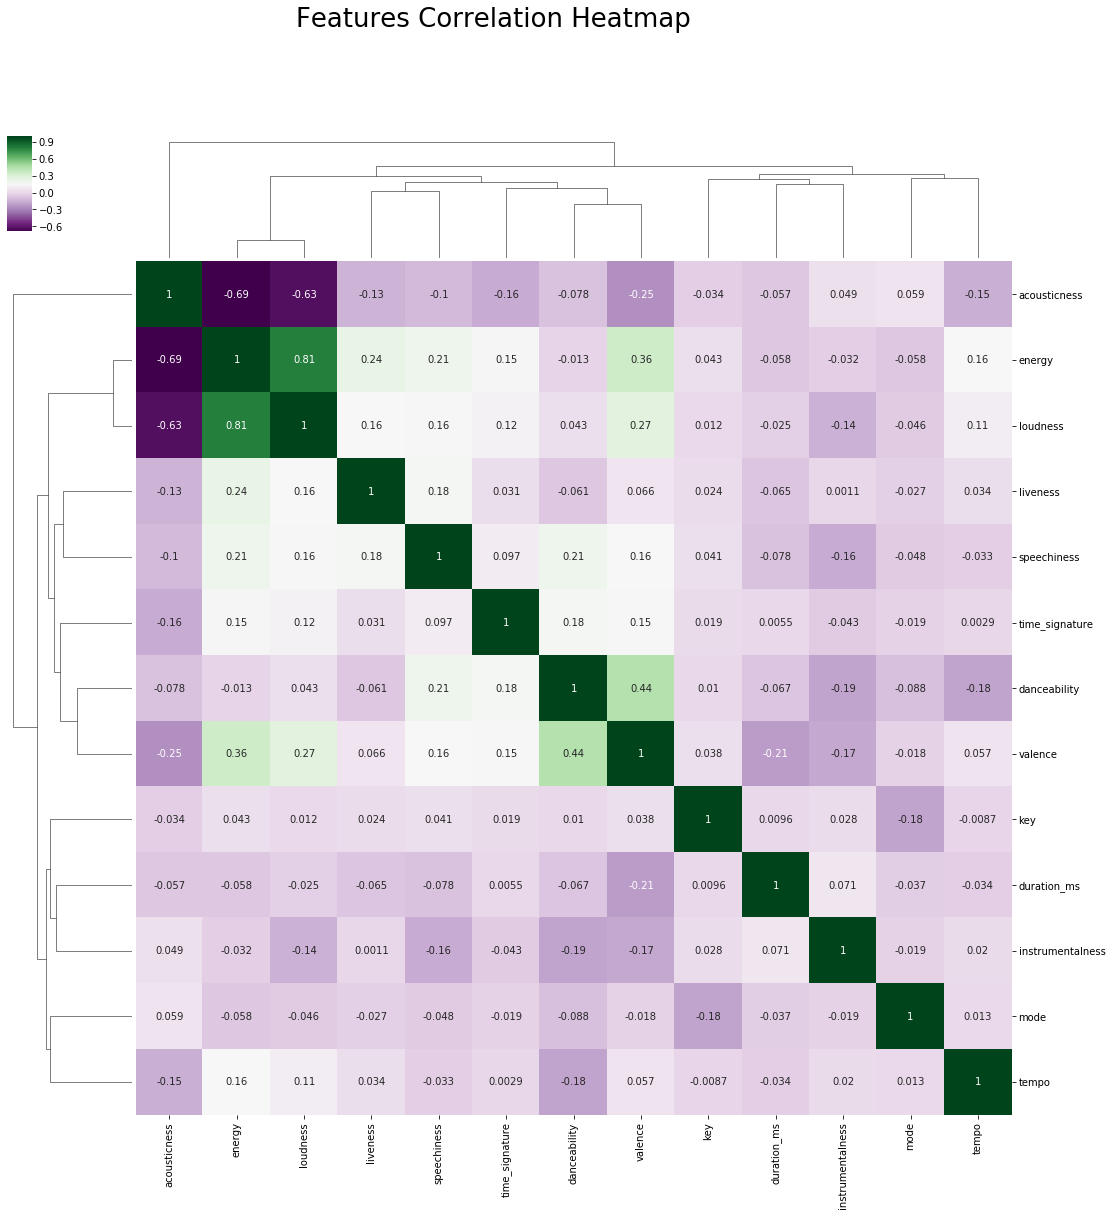

In [ ]:
features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 
          'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']

cm_features = feature_data[features]
sns.clustermap(cm_features.corr(), cmap='PRGn', annot=True, figsize=(18,18))
plt.suptitle('Features Correlation Heatmap', fontsize=26)

* Acousticness: tells us if the song uses mainly acoustic instruments or electronic/electric instruments. A value of 1.0 indicates that a song is purely acoustic, and from the histogram it appears a majority of songs use electronic instruments over acoustic instruments.
* Danceability: how suitable a track is for dancing based on a combination of sound traits such as tempo, rhythm, and beat. A with a value of 1.0 indicates high danceability, and here it seems to be normally distributed.
* Duration: Measured in milliseconds, gives the length of the song. Most songs are between 3-5 minutes long.
* Energy: Measure of intensity and activity. Energetic tracks feel dense, fast, loud, and noisy. Typically, energetic tracks feel fast, loud, and noisy (think death metal) while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. Songs are skewed towards having higher energy.
* Instrumentalness: The extent to which the singer, aside from ‘oohs’ and ‘aahs’, is not the primary performer of the song. Here we see songs are mostly vocal.
* Key represents the key signature the track is in. Integers map to pitches using standard pitch class notation where 0 = C, 1 = C#/Db, 2 = D, etc.
* Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the song was performed and recorded live. It is seen that most songs are studio-recorded.
* Loudness: Measured in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. It also is the quality of a sound that is the primary psychological correlate of physical strength (amplitude), with values averaging between -60dB and 0dB.
* Mode: Whether a song is in primarily a major key or a minor key. Major key songs sound generally more upbeat while songs in the minor key sound more somber. Most songs seen here are in the major key.
* Speechiness: Detects the presence of spoken words in a recording. The more exclusively speech-like the recording (eg. audio books), the closer the speechiness is to 1.0. The jump near the end for speechiness are most likely from rap.
* Tempo: Describes speed, or the number of beats per minute (BPM). Tempo roughly appears to be normally distributed around 120BPM.
* Time signature: Notational convention to specify how many beats are in each bar of music. Almost all songs have 4 beats per bar, but a small number, probably ballads, have 3 beats per bar. 
* Valence: Describes the musical positiveness. Songs with high valence sound more cheerful while songs with low valance sound more depressed/angry. The graph shows that songs are more likely to have high valance, which follows how most songs are in the major key

Text(0.5, 0.98, 'Features Correlation Heatmap')

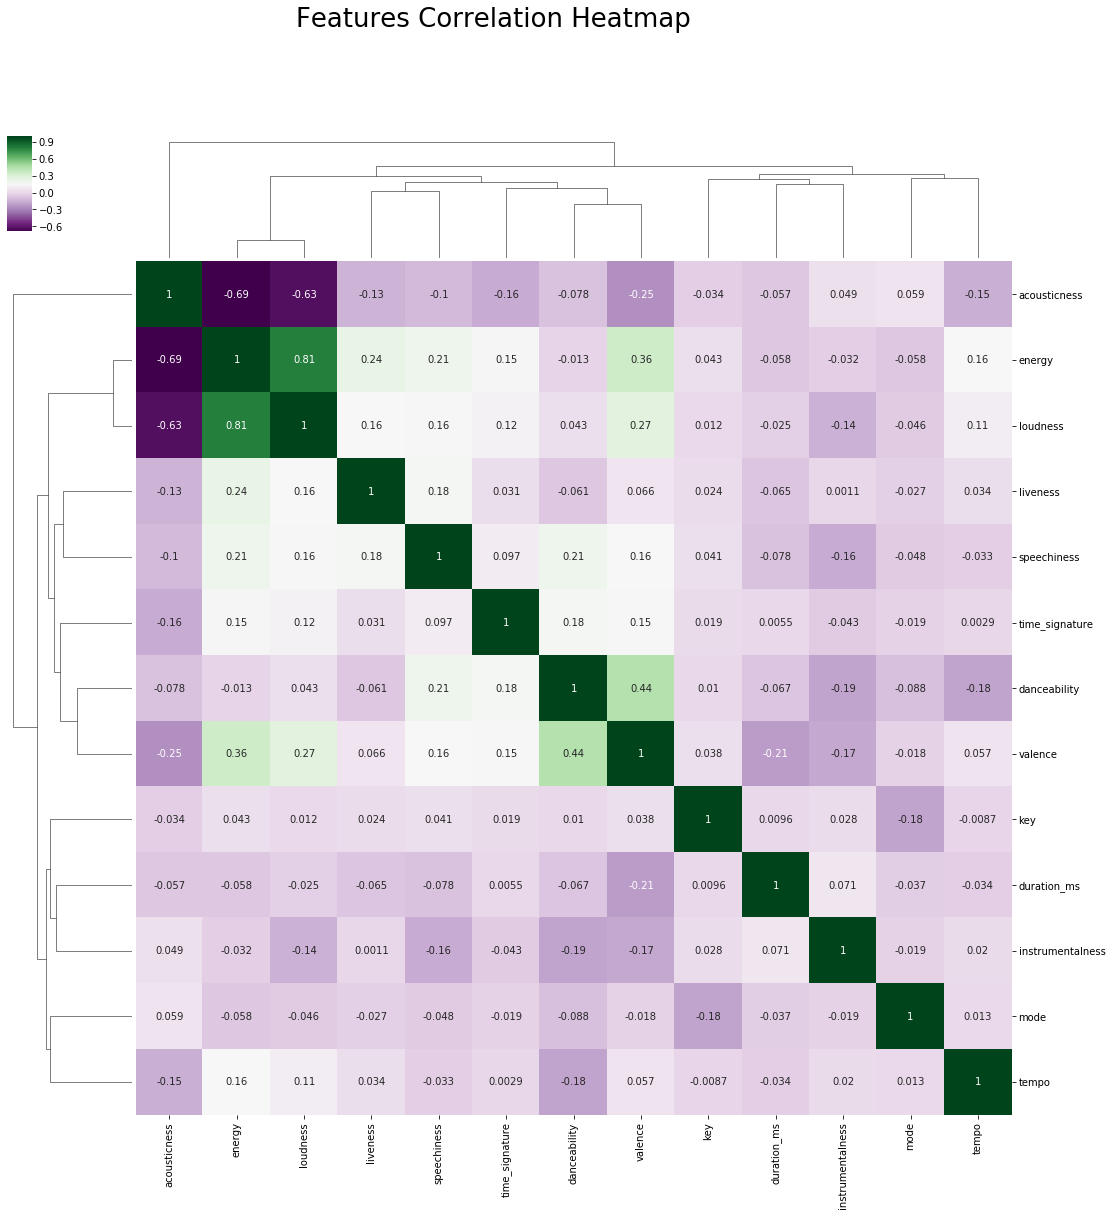

In [ ]:
#Diverging maps
features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 
          'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']

cm_features = data[features]
sns.clustermap(cm_features.corr(), cmap='PRGn', annot=True, figsize=(18,18))
plt.suptitle('Features Correlation Heatmap', fontsize=26)

#####Bivariate Distribution
We see that the most significant correlations involve energy and acousticness. Because we are interested in lyrics, we look further into this feature correlation with the acoustic feature 'speechiness'.

0.2059967625045701 -0.15598335005762912


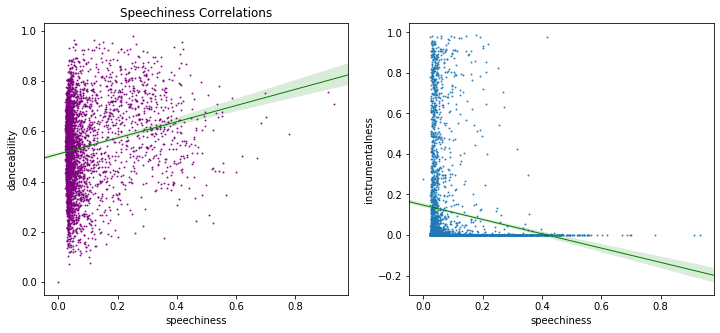

In [ ]:
f = plt.figure(figsize=(12,5))

ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

x = np.linspace(0,4,1000)
ax.set(title='Speechiness Correlations')
sns.regplot(data=feature_data, x=feature_data['speechiness'], y=feature_data['danceability'], color= 'purple',
            line_kws= {'linewidth': 1, 'color': 'green'}, scatter_kws={'s': 1}, label='test', ax=ax)

sns.regplot(data=feature_data, x=feature_data['speechiness'], y=feature_data['instrumentalness'], 
            line_kws= {'linewidth': 1, 'color': 'green'}, scatter_kws={'s': 1}, label='test', ax=ax2)
print(np.corrcoef(feature_data['speechiness'], feature_data['danceability'])[0][1], 
      np.corrcoef(feature_data['speechiness'], feature_data['instrumentalness'])[0][1])

# Genre VS Acoustic Features 

### Rescaling/standardizing data

Now we need to preprocess the values for audio features in our data. The first thing we need to do is to convert the date to numerical values. Now they are presented as strings. We can transform them by calculating how many seconds have passed since a fixed time. Here we chose the 1970 epoch.

In [ ]:
data.head()

artist   index  ... score                                             lyrics
0  eminem  1024.0  ...   6.9  WHOOOO!!!\nHey, how you guys doin.\nYou want m...
1  eminem  1025.0  ...   6.9  Ah ah ah ahhh (Oh god damn)(Ooh)\nI'm gonna fa...
2  eminem  1026.0  ...   6.9  Whatever\nDre just let it run\nEy yo turn the ...
4  eminem  1027.0  ...   6.9  Hi! My name is (what?)\nMy name is (who?)\nMy ...
5  eminem  1028.0  ...   6.9  My tea's gone cold I'm wondering why I\nGot ou...

[5 rows x 20 columns]

In [ ]:
num = data.iloc[:, 3:17] # selecting the features with numerical data
num.head()

acousticness  danceability  duration_ms  ...  time_signature  valence        date
0       0.14000         0.374      33987.0  ...             5.0    0.146  2005-12-06
1       0.00629         0.840     205760.0  ...             4.0    0.346  2005-12-06
2       0.13700         0.810     291120.0  ...             4.0    0.323  2005-12-06
4       0.04110         0.860     268853.0  ...             4.0    0.833  2005-12-06
5       0.03780         0.779     404427.0  ...             4.0    0.533  2005-12-06

[5 rows x 14 columns]

In [ ]:
from datetime import date
from datetime import datetime
#convert date string to datetime and then get the timestamp since 1970-1-1
num['date'] = num.date.apply(pd.to_datetime).apply(datetime.timestamp) 
num

acousticness  danceability  ...  valence          date
0          0.14000         0.374  ...    0.146  1.133827e+09
1          0.00629         0.840  ...    0.346  1.133827e+09
2          0.13700         0.810  ...    0.323  1.133827e+09
4          0.04110         0.860  ...    0.833  1.133827e+09
5          0.03780         0.779  ...    0.533  1.133827e+09
...            ...           ...  ...      ...           ...
4338       0.03590         0.473  ...    0.486 -6.315840e+07
4339       0.19800         0.280  ...    0.267 -6.315840e+07
4340       0.16100         0.435  ...    0.692 -6.315840e+07
4341       0.11800         0.316  ...    0.558 -6.315840e+07
4342       0.28900         0.385  ...    0.351 -6.315840e+07

[3772 rows x 14 columns]

Now we standardize the numerical data so that they have mean 0 and variance 1 (since their scales vary greatly).

In [ ]:
from sklearn import preprocessing
# Get column names first
names = num.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit data on the scaler object
scaled = scaler.fit_transform(num)
scaled = pd.DataFrame(scaled, columns=names)
scaled

acousticness  danceability  ...   valence      date
0        -0.294389     -0.994263  ... -1.341351 -0.406588
1        -0.759276      1.806134  ... -0.490636 -0.406588
2        -0.304820      1.625851  ... -0.588468 -0.406588
3        -0.638247      1.926323  ...  1.580857 -0.406588
4        -0.649721      1.439559  ...  0.304783 -0.406588
...            ...           ...  ...       ...       ...
3767     -0.656327     -0.399329  ...  0.104865 -5.433553
3768     -0.092733     -1.559150  ... -0.826668 -5.433553
3769     -0.221376     -0.627687  ...  0.981102 -5.433553
3770     -0.370879     -1.342810  ...  0.411123 -5.433553
3771      0.223658     -0.928159  ... -0.469368 -5.433553

[3772 rows x 14 columns]

## PCA

First create the data's 2D projection for visualization 

In [ ]:

from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
X = pca2.fit_transform(scaled)

# create a df
pca2_scaled = pd.DataFrame(X, columns = ['pc1', 'pc2'])
#pca_scaled['acousticness'] = scaled['acousticness']
pca2_scaled

pc1       pc2
0     0.412380 -0.053084
1    -0.165107  0.899531
2    -1.544150  1.034474
3    -1.667963  2.782408
4    -1.534337  1.051540
...        ...       ...
3767  2.762882 -0.043907
3768  2.579891 -0.195241
3769  1.396313  1.992760
3770  1.989902  0.916217
3771  2.592698 -0.351003

[3772 rows x 2 columns]

Then we can visualize them.

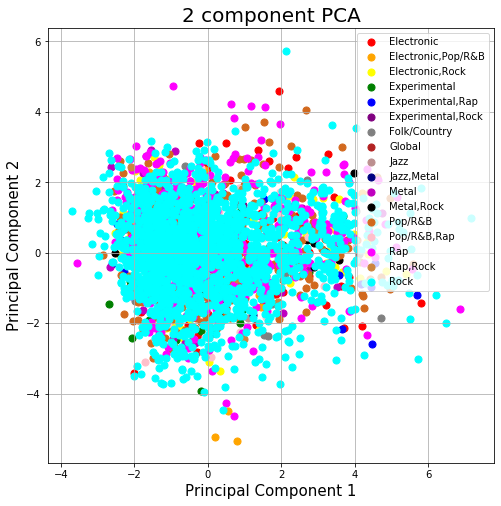

In [ ]:
final_pca2_scaled = pca2_scaled
final_pca2_scaled['target'] = data['genre']

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Electronic', 'Electronic,Pop/R&B', 'Electronic,Rock',
       'Experimental', 'Experimental,Rap', 'Experimental,Rock',
       'Folk/Country', 'Global', 'Jazz', 'Jazz,Metal', 'Metal',
       'Metal,Rock', 'Pop/R&B', 'Pop/R&B,Rap', 'Rap', 'Rap,Rock', 'Rock']
colors = ['red', 'orange', 'yellow',
       'green', 'blue', 'purple',
       'gray', 'firebrick', 'rosybrown', 'navy', 'm',
       'black', 'chocolate', 'pink', 'magenta', 'peru', 'aqua']
for target, color in zip(targets,colors):
    indicesToKeep = final_pca2_scaled['target'] == target
    ax.scatter(final_pca2_scaled.loc[indicesToKeep, 'pc1']
               , final_pca2_scaled.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Here we can see that different genres don't separate well from each other in 2D. We see a lot of blue/aqua dots which are rock songs since they occupy the largest proportion in our dataset. They seem to scatter around the plot without any prominent clustering.

Check the first two most important features

In [ ]:
pca2_component = pd.DataFrame(pca2.components_)

for i in range(14):
  if abs(pca2_component.loc[0, :][i]) == max(abs(pca2_component.loc[0, :])):
    first_important_feature = scaled.columns[i]
for j in range(14):
  if abs(pca2_component.loc[1, :][j]) == max(abs(pca2_component.loc[1, :])):
    second_important_feature = scaled.columns[j]

print("It can be seen that", first_important_feature, "and", second_important_feature, "are the first two most prominent features for genres.")


It can be seen that energy and danceability are the first two most prominent features for genres.


A 2D projection is convenient for visualization, but this would cause some information loss. If too much information is lost, the dimension reduction would not be acceptable. To know how much information is lost, get the percent of explained variance by two components.

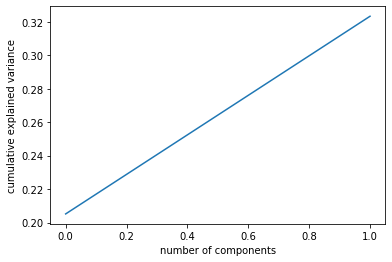

In [ ]:
#Explained variance
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

We can see that only around 32% variance is explained by two components, which means that much information is lost and thus more components are needed.

So check how many components are needed to explain at least 90% of  variance

In [ ]:
least_num = len(pd.DataFrame(PCA(0.9).fit_transform(scaled)).columns)
print(least_num, "components are needed to explain at least 90% of variance.")

11 components are needed to explain at least 90% of variance.


As there are 14 features in total, reducing the number of dimensions to 11 is not a significant improvement. Since in this case, effective reduce of dimensions would cause significant information loss, using dimesion reduction to classify genres is not wise.

#Genres VS Lyrics

We are going to shift our focus from accoustic features to lyrics. Next We look at the relationship between generes and lyrics to see if or what kind of connections exist between them. We attempt to extract a certain number of topics from them and categorize the songs based on the topics. Finally we want to check how well our categorization matches the genre. 

## Preprocessing Text

First of all, we need to preprocess the text data. Here we use the Natural Language Toolkit (nltk) framework to process the text corpus. A text corpus is a body of text where each paragraph comprises of several sentences, which in our cases our text corpus is of lyrics. We need to clean and standardize the text data so that they can be used for subsequent analysis.

In [ ]:
! pip install nltk

In [ ]:
# import packages needed
import nltk, string, re
nltk.download('stopwords')
nltk.download('punkt') # tockenizer
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()
nltk.download(['averaged_perceptron_tagger',
               'universal_tagset',
               'wordnet'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Tokenization

NLTK provides the function word_tokenizer( ) that splits a string of text into tokens (usually words) based on white space and punctuations.

In [ ]:
def tokenize_text(text):
    tokens = nltk.word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens

Now let's try tokenizing one of the lyrics in our dataset.

In [ ]:
tokenize_text(data.lyrics[5])[:30] # return the first 30 tokens

['My',
 'tea',
 "'s",
 'gone',
 'cold',
 'I',
 "'m",
 'wondering',
 'why',
 'I',
 'Got',
 'out',
 'of',
 'bed',
 'at',
 'all',
 'The',
 'morning',
 'rain',
 'clouds',
 'up',
 'my',
 'window',
 'And',
 'I',
 'ca',
 "n't",
 'see',
 'at',
 'all']

We can see that the string of lyrics is splitted into a list of tokens. Most of them are meaningful words while there are some punctuations and fragments. It appears that some words like "I'm" and "can't" get in the way of tokenization.

### Expanding Contractions

We decided to remove the contractions, which are shorterned versions of words. They are commonly used in spoken/ written english and we find them a lot in song lyrics. Here, we used the contraction map provided in the lecture that includes common contractions in English. The map is a dictionary whose keys are the contractions and the values are the corresponding expanded expressions. In this way we can map each contraction to regular words without punctuations. 

In [ ]:
! wget -nc -nv https://raw.githubusercontent.com/dipanjanS/text-analytics-with-python/master/Old-First-Edition/source_code/Ch04_Text_Classification/contractions.py
from contractions import CONTRACTION_MAP
CONTRACTION_MAP

2020-01-14 05:45:12 URL:https://raw.githubusercontent.com/dipanjanS/text-analytics-with-python/master/Old-First-Edition/source_code/Ch04_Text_Classification/contractions.py [3052/3052] -> "contractions.py" [1]


{"'cause": 'because',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',
 "ain't": 'is not',
 "aren't": 'are not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he would',
 "he'd've": 'he would have',
 "he'll": 'he will',
 "he'll've": 'he he will have',
 "he's": 'he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "i'd": 'i would',
 "i'd've": 'i would have',
 "i'll": 'i will',
 "i'll've": 'i will have',
 "i'm": 'i am',
 "i've": 'i have',
 "isn't": 'is not',
 "it'd": 'it would',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'mad

We defined a function that replaces every occurance of contraction in our contraction map with the corresponding expanded form.

In [ ]:
def expand_contraction(text, contraction_map):
    regex = r"\b(?:" + "|".join(re.escape(word) for word in contraction_map) + r")\b"
    reobj = re.compile(regex, re.I)
    return reobj.sub(lambda x: contraction_map[x.group(0)], text)

Again, we applied the function to our lyrics to check how it works.

In [ ]:
text = print(expand_contraction(data.lyrics[2].lower(), CONTRACTION_MAP))
text

whatever
dre just let it run
ey yo turn the beat up a little bit
ey yo this song is for anyone
fuck it just shut up and listen
ey yo
i sit back, with this pack, of zigzags
and this bag, of this weed
it gives me, the shit needed to be, the most meanest mc on this
on this earth 'cause since birth i have been cursed with this curse to just curse
and just blurt this berserk and bizarre shit that works
and it sells and it helps in its self to relieve
all this tension dispensing me, sentence is getting it
the stress has been eating me, recently
off of this chest and i rest to get peacefully
but at least have the decency in you to leave me alone
when you freaks see me out in the streets
when i am eating or feeding my daughter to not come and speak to me
i do not know you and no i do not owe you a motherfuckin' thing
i am not mr.'n sync and i am not what your friends think
i am not mr.friendly, i can be a prick, if you tempt me my tank is on empty
no patience is in me and if you offend me i am

From the output, we can see that many contractions are successfully expanded, such as "I'm" --> "I am". However, there are still some shortened words like "'til". We need to deal with the issue.

#### Improving contraction map

While we have made improvements of the texts by expanding contractions, there are still some problems:

*   Some shortened versions of words like "doin" "wanna" 
are not included in the contraction map we are using. We needed to add them to the map.

*   Some words are spelled in alternative forms, like "ah/ahh", "fuck/fack". We need to standardize them so that they will not be counted as different words.

*  There are many interjections like "oh" "hey" 'yo" that occur frequently in lyrics but do not contain actual meanings. We don't want to delete them since they may help us distinguish certain genres. For instance, a rap song may contain more of such words than other types of songs. Nevertheless, it would be hard to keep track of all of them since there are so many variations; we also do not want our topics to contain all words like "ah" and "hey". There is a trade-off: if we want to extract meaningful topics, we have to standardize the these words and lose some information. We decided to simply use 'ah' as a marker to replace all occurances of such words since we are not interested in specifically what types of interjections they are.

We need to deal with these problems by updating our contraction map. Below are the words that we see frequently in our lyrics and we think they may cause problems. So we mannually added them to the contraction map.

In [ ]:
new_contraction = {
    "bein'": 'being',
    "'bout": 'about',
    "bout": 'about',
    'callin':'calling',
    'cause': 'because',
    'comin':'coming',
    'cus': 'because',
    'doin':'doing',
    "'em":'them',
    "em":'them',
    'fack':'fuck',
    'faack':'fuck',
    'fackin':'fucking',
    'fuckin':'fucking',
    'talkin':'talking',
    'gettin':'getting',
    'gimme': 'give me',
    "gon'":'going to',
    "gon na":'going to',
    'gonna': 'going to',
    'gotta':'got to',
    "havin'": 'having',
    "i'ma": 'i am going to',
    "ima": 'i am going to',
    "imma":'i am going to',
    "i'mma":'i am going to',
    'knowin':'knowing',
    "'ll":'will',
    "ll":'will',
    'lookin':'looking',
    "lovin":'loving',
    'lettin':'letting',
    'niggas':'nigga',
    'nothin':'nothing',
    'outta':'out of',
    'somethin':'something',
    'til':'till',
    "'til":'till',
    "'till":'till',
    'tryna': 'trying to',
    'wanna':'want to',
    'walkin':'walking',
    'ya':'you',
    # mark all interjections as ah
    'aah':'ah',
    'ahh':'ah',
    'ahhh':'ah',
    'ba':'ah',
    'di':'ah',
    'da':'ah',
    'ey':'ah',
    'hey':'ah',
    'hmm':'ah',
    'hoo':'ah',
    'huh': 'ah',
    'la':'ah',
    "lahlahlah":'ah',
    'nah':'ah',
    'oh':'ah',
    'ooh':'ah',
    'uh':'ah',
    'whoa':'ah',
    'woa':'ah',
    'woo':'ah',
    'yo':'ah',
    'ye':'ah',
    'yeah':'ah'
}
CONTRACTION_MAP.update(new_contraction) # add new contractions to the original contraction map
CONTRACTION_MAP

{"'bout": 'about',
 "'cause": 'because',
 "'em": 'them',
 "'ll": 'will',
 "'til": 'till',
 "'till": 'till',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',
 'aah': 'ah',
 'ahh': 'ah',
 'ahhh': 'ah',
 "ain't": 'is not',
 "aren't": 'are not',
 'ba': 'ah',
 "bein'": 'being',
 'bout': 'about',
 'callin': 'calling',
 "can't": 'cannot',
 "can't've": 'cannot have',
 'cause': 'because',
 'comin': 'coming',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 'cus': 'because',
 'da': 'ah',
 'di': 'ah',
 "didn't": 'did not',
 "doesn't": 'does not',
 'doin': 'doing',
 "don't": 'do not',
 'em': 'them',
 'ey': 'ah',
 'faack': 'fuck',
 'fack': 'fuck',
 'fackin': 'fucking',
 'fuckin': 'fucking',
 'gettin': 'getting',
 'gimme': 'give me',
 'gon na': 'going to',
 "gon'": 'going to',
 'gonna': 'going to',
 'gotta': 'got to',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has

In [ ]:
text = expand_contraction(data.lyrics[2].lower(), CONTRACTION_MAP)
text

'whatever\ndre just let it run\nah ah turn the beat up a little bit\nah ah this song is for anyone\nfuck it just shut up and listen\nah ah\ni sit back, with this pack, of zigzags\nand this bag, of this weed\nit gives me, the shit needed to be, the most meanest mc on this\non this earth \'because since birth i have been cursed with this curse to just curse\nand just blurt this berserk and bizarre shit that works\nand it sells and it helps in its self to relieve\nall this tension dispensing me, sentence is getting it\nthe stress has been eating me, recently\noff of this chest and i rest to get peacefully\nbut at least have the decency in you to leave me alone\nwhen you freaks see me out in the streets\nwhen i am eating or feeding my daughter to not come and speak to me\ni do not know you and no i do not owe you a motherfuckin\' thing\ni am not mr.\'n sync and i am not what your friends think\ni am not mr.friendly, i can be a prick, if you tempt me my tank is on empty\nno patience is in m

Even though contractions are not compeletly eliminated, we got rid of those common ones and we will not take care of the rare ones that are unlikely to have much influence on the result.

### Removing special characters

It is important to delete punctuations or special characters that do not contain much meanings. We do not want them when we analyze the lyrics and extract information from them. So we defined a function to filter them out.

In [ ]:
def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation))) # escape all punctuation characters
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens]) 
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [ ]:
text = remove_special_characters(text)
text

'whatever dre just let it run ah ah turn the beat up a little bit ah ah this song is for anyone fuck it just shut up and listen ah ah i sit back with this pack of zigzags and this bag of this weed it gives me the shit needed to be the most meanest mc on this on this earth because since birth i have been cursed with this curse to just curse and just blurt this berserk and bizarre shit that works and it sells and it helps in its self to relieve all this tension dispensing me sentence is getting it the stress has been eating me recently off of this chest and i rest to get peacefully but at least have the decency in you to leave me alone when you freaks see me out in the streets when i am eating or feeding my daughter to not come and speak to me i do not know you and no i do not owe you a motherfuckin thing i am not mrn sync and i am not what your friends think i am not mrfriendly i can be a prick if you tempt me my tank is on empty no patience is in me and if you offend me i am lifting yo

### Remove stopwords

We used a list of stopwords containing words that occur frequently in any English texts. Since they are common in most texts and do not tell us anything about a certain document, they are insignificant and we want to exclude them.

In [ ]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
ENGLISH_STOP_WORDS

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

We defined a function that check each token and only keep it if it's not in the list of stopwords.

In [ ]:
def remove_stopwords(text,stopword_list):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [ ]:
stopwords = list(ENGLISH_STOP_WORDS)
text = remove_stopwords(text, stopwords)
text

'dre just let run ah ah turn beat little bit ah ah song fuck just shut listen ah ah sit pack zigzags bag weed gives shit needed meanest mc earth birth cursed curse just curse just blurt berserk bizarre shit works sells helps self relieve tension dispensing sentence getting stress eating recently chest rest peacefully decency leave freaks streets eating feeding daughter come speak know owe motherfuckin thing mrn sync friends think mrfriendly prick tempt tank patience offend lifting feet air care saw just jaw lawyer file lawsuit smile courtroom buy wardrobe tired mean mean just say say papers news everyday radio play jam say say papers news everyday know just way just feel like father hate bothered nonsense constant ah lyrical content song guilty conscience gotten rotten responses controversy circles like media immediately points finger point index pinky ring thumb fuck just bullshit pull shit dude s getting bullied shoots school blame marilyn heroin parents look middle america tragedy s

We can see that many of the common words were removed and the words left are more or less related to the specific content of the lyrics

### Identifying parts-of-speech + lemmatization

In many situations, words appear with the inflected form like "walked" instead of the lemma "walk". In text mining, we would like to count occurrences of a word without regard to which inflected form was used. Thus, we implemented another function to standardize the lyrics. Using NLTK, we can get the part-of-tag of each word token and then lemmatize words to their base forms (root words).

In [ ]:
from nltk import pos_tag
from nltk.corpus import wordnet as wn

# Annotate text tokens with POS tags
def pos_tag_text(text):
    
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None

    tagged_text = pos_tag(text)
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_lower_text

In [ ]:
# lemmatize text based on POS tags    
def lemmatize_text(text):
    text = tokenize_text(text)
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word                     
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [ ]:
text = lemmatize_text(text)
text

'dre just let run ah ah turn beat little bit ah ah song fuck just shut listen ah ah sit pack zigzag bag weed give shit need mean mc earth birth curse curse just curse just blurt berserk bizarre shit work sell help self relieve tension dispense sentence get stress eat recently chest rest peacefully decency leave freak street eat feed daughter come speak know owe motherfuckin thing mrn sync friend think mrfriendly prick tempt tank patience offend lift foot air care saw just jaw lawyer file lawsuit smile courtroom buy wardrobe tired mean mean just say say paper news everyday radio play jam say say paper news everyday know just way just feel like father hate bother nonsense constant ah lyrical content song guilty conscience gotten rotten response controversy circle like medium immediately point finger point index pinky ring thumb fuck just bullshit pull shit dude s get bully shoots school blame marilyn heroin parent look middle america tragedy sad upper class city have happen attack eminem

After lemmatization, words like "zigzags" "needed" are converted to their base forms "zigzag" and "need". This helps us deal with unique words without encountering inflected forms.

### Normalization

We combined all of our functions into one called normalize_text().

In [ ]:
# Text normalization pipeline
def normalize_text(text,tokenize=False):
    text = text.lower()
    text = expand_contraction(text, CONTRACTION_MAP)
    text = remove_special_characters(text)
    text = lemmatize_text(text)
    text = remove_stopwords(text, stopwords)

    return text

Now apply the ultimate function to normalize all lyrics in our dataset.

In [ ]:
# takes a very long time
lyrics = data.lyrics.apply(normalize_text)
lyrics

0       whoooo ah guy want alright shut shoobeedoo sho...
1       ah ah ah ah ah god damn ah fuck cum ah shit ah...
2       dre just let run ah ah turn beat little bit ah...
4       hi slim shady hi ah slim shady hi excuse slim ...
5       tea s cold wonder bed morning rain cloud windo...
                              ...                        
4338    whew ah alright just want say love night long ...
4339    help doctor doctor need pain killer doc shot i...
4340    alright cold cold darkness past confusion quic...
4341    sit parchment farm sit parchment farm sit parc...
4342    listen baby time sorry end line know say know ...
Name: lyrics, Length: 3772, dtype: object

Compare the normalized texts with the original ones.

In [ ]:
 data.lyrics[1]

"Ah ah ah ahhh (Oh god damn)(Ooh)\nI'm gonna fackin cum (Oh shit)(oh yeah)\nFack fack faack, (Fuck I am) (Ooh)\nI am, I'm going to cum\nI'm cumming (oh yeah)\nI never seen no shit like this,\nThis bitch can twist like a damn contortionist\nCondom on my dick of course it is,\nThis bitch don't know what abortion is\nSo I can't cum in her, fucks like a porn star, looks like Jenna,\nFack I'm gonna,\nCum I think my rubbers comin' off,\nBut oh its so fuckin' wet and soft,\nFuck, I'm gonna start lettin' off\nI'm squirting and she's not gettin' off,\nAnd she's on top, I'm gonna fackin', oh god,\nOh don't do that, don't, stop\nStop, don't, I don't mean don't stop!\nOw wait a minute, ow ow fuck I, I'm gonna fuckin' cam!\nAh ah ah ahhh (Oh god damn)(Ooh)\nI'm gonna fackin cum (Oh shit)(oh yeah)\nFack fack faack, (Fuck I am) (Ooh)\nI am, I'm going to cum\nI'm cumming (oh yeah)\nOh wow, boo that pow, ooh ow I need a cigarette now!\nOh I'm so fucking hot, and you're so fucking hot,\nOh my god, I wan

In [ ]:
lyrics[1]

'ah ah ah ah ah god damn ah fuck cum ah shit ah ah fuck fuck fuck fuck ah cum cumming ah ah shit like bitch twist like damn contortionist condom dick course bitch know abortion cum fuck like porn star look like jenna fuck cum think rubber come ah fucking wet soft fuck start let squirt fuck ah god ah stop stop mean stop ow wait minute ow ow fuck fuck cam ah ah ah ah ah god damn ah fuck cum ah shit ah ah fuck fuck fuck fuck ah cum cumming ah ah ah wow boo pow ah ow need cigarette ah fucking hot fucking hot ah god want fuck fuck fuck say fuck fack fack fuck fuck fuck fuck freak ah ah girl baby mr freaky let sister 3way threesome horny fucking babe want fuck shave ohh god damn cum ah ah ah ah ah god damn ah fuck cum ah shit ah ah fuck fuck fuck fuck ah cum cumming ah ah ok come twice make cam gas fast ah finger just ow hurt ah wait minute oww mean gay like men like boob boob boob gerbil grab tube shove butt let little rascal nibble asshole uhh ah right right ah come ah ah fuck just come ok

We have normalized the data and we can use them for topic extraction. Before moving on to the next step, we wanted to take a look at the lyrics and see what are some keywords in them.

### Review & Visualization

The function nltk.FreqDist() computes the frequency of each word in a list. We combined all normalized lyrics into a string and tokenize them into a list of words. Then we applied nltk.FreqDist() to get the 100 most frequent words.

In [ ]:
all_lyrics = '\n'.join(lyrics) # make a long string of the lyrics
all_lyrics = [word for word in tokenize_text(all_lyrics)] # tokenize the lyrics
word_freq = nltk.FreqDist(all_lyrics).most_common(100) # the 100 most frequent words
word_freq

[('ah', 12538),
 ('know', 7249),
 ('like', 6485),
 ('just', 5203),
 ('love', 5170),
 ('want', 5078),
 ('come', 4295),
 ('say', 3982),
 ('make', 3572),
 ('time', 3419),
 ('let', 2970),
 ('s', 2909),
 ('feel', 2503),
 ('tell', 2470),
 ('baby', 2457),
 ('way', 2369),
 ('look', 2305),
 ('nigga', 2299),
 ('think', 2127),
 ('good', 2123),
 ('day', 2038),
 ('need', 1985),
 ('right', 1981),
 ('fuck', 1877),
 ('try', 1868),
 ('life', 1866),
 ('girl', 1745),
 ('night', 1737),
 ('thing', 1729),
 ('away', 1710),
 ('leave', 1629),
 ('man', 1603),
 ('heart', 1577),
 ('shit', 1518),
 ('eye', 1425),
 ('world', 1346),
 ('light', 1321),
 ('run', 1285),
 ('mind', 1266),
 ('little', 1220),
 ('hold', 1213),
 ('long', 1161),
 ('lose', 1141),
 ('wait', 1138),
 ('bitch', 1127),
 ('hand', 1127),
 ('live', 1122),
 ('fall', 1093),
 ('turn', 1071),
 ('talk', 1041),
 ('head', 1023),
 ('dream', 1023),
 ('walk', 1003),
 ('stop', 1002),
 ('break', 999),
 ('home', 990),
 ('hear', 987),
 ('work', 944),
 ('money', 940),

We noticed that there is still something we don't want, such as "s", which may come from the possessive form of nouns or the contraction of "... is/has", and "chorus", which is the description instead of a part of lyrics. So we updated our stopword list to exclude these words from our data.

In [ ]:
new_stopwords = [
    'instrumental',
    'chorus',
    'em',
    'na',
    's',
    'x2',]
stopwords.extend(new_stopwords)

# normalize our lyrics data again with updated stopwords
lyrics = data.lyrics.apply(normalize_text)

Take a look at the word frequency again.

In [ ]:
all_lyrics = '\n'.join(lyrics) # make a long string of the lyrics
all_lyrics = [word for word in tokenize_text(all_lyrics)] # tokenize the lyrics
word_freq = nltk.FreqDist(all_lyrics).most_common(100) # the 100 most frequent words
word_freq

[('ah', 12538),
 ('know', 7249),
 ('like', 6485),
 ('just', 5203),
 ('love', 5170),
 ('want', 5078),
 ('come', 4295),
 ('say', 3982),
 ('make', 3572),
 ('time', 3419),
 ('let', 2970),
 ('feel', 2503),
 ('tell', 2470),
 ('baby', 2457),
 ('way', 2369),
 ('look', 2305),
 ('nigga', 2299),
 ('think', 2127),
 ('good', 2123),
 ('day', 2038),
 ('need', 1985),
 ('right', 1981),
 ('fuck', 1877),
 ('try', 1868),
 ('life', 1866),
 ('girl', 1745),
 ('night', 1737),
 ('thing', 1729),
 ('away', 1710),
 ('leave', 1629),
 ('man', 1603),
 ('heart', 1577),
 ('shit', 1518),
 ('eye', 1425),
 ('world', 1346),
 ('light', 1321),
 ('run', 1285),
 ('mind', 1266),
 ('little', 1220),
 ('hold', 1213),
 ('long', 1161),
 ('lose', 1141),
 ('wait', 1138),
 ('bitch', 1127),
 ('hand', 1127),
 ('live', 1122),
 ('fall', 1093),
 ('turn', 1071),
 ('talk', 1041),
 ('head', 1023),
 ('dream', 1023),
 ('walk', 1003),
 ('stop', 1002),
 ('break', 999),
 ('home', 990),
 ('hear', 987),
 ('work', 944),
 ('money', 940),
 ('really', 9

It seemed that we have the data we want now. We generated a word cloud to visualize these most frequent words.

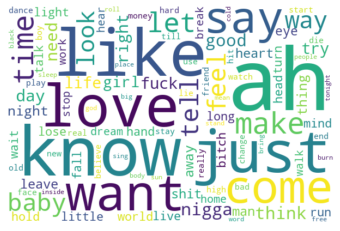

In [ ]:
from wordcloud import WordCloud
d = {}
for word, freq in word_freq:
    d[word] = freq
# generate word cloud based on the word frequency and set its size and color
wordcloud = WordCloud(height=400, width=600, background_color='White')
wordcloud.generate_from_frequencies(frequencies=d) 
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Unsurprisingly, "ah" becomes the most frequent word because we mapped all interjections to it. It shows that interjections are used a lot in lyrics. The others words seem to be what we usually hear in songs too.

##Feature Extraction

Now that the text is cleaned we need to convert it into numerical data before we can analyse it. We chose to use the Term Frequency - Inverse Document Frequency Model (TF-IDF) for feature extraction because it does a good job of evenly weighting all the documents (in this case song lyrics).

### TF - IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(lyrics).T
print(X.shape) # words, lyrics

feature_names = vectorizer.get_feature_names()

(22890, 3772)


## Topic Discovery

We use Non negative Matrix Factorization (NMF) specifically for topic discovery. Later we will use these generated topics to compare with genres and interpret the connections between them.

### Non negative Matrix Factorization

In [ ]:
## Non-negative Matrix Factorization
def non_negative_marix_decomp(n_components,train_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, 
                     init='nndsvda', max_iter=500, 
                     random_state=0)
    W = model.fit_transform(train_data)
    H = model.components_
    nmf = (W,H)
    return(nmf)

We will be splitting the Matrix X in to W (the base matrix) and H (the coefficient matrix). The base matrix contains the lyrics contribution to the generated topics and the coefficient matrix contains the importance of the topics to each song. We will try generating different amounts of topics and look for meaningful results. 

In [ ]:
r = 2 # no. of topics
W_topic2,H_topic2 = \
    non_negative_marix_decomp(n_components = r, train_data = X)

In [ ]:
r = 5 # no. of topics
W_topic5,H_topic5 = \
    non_negative_marix_decomp(n_components = r, train_data = X)

In [ ]:
# Takes a long time
r = 17 # no. of topics
W_topic17,H_topic17 = \
    non_negative_marix_decomp(n_components = r, train_data = X) 

H_topic17 /= H_topic17.sum(0)

## Inspecting Topics

Now that we have generated topics we need to see if the seem to have made any sensible groupings

### Word cloud for topic

Lets start with visualizing some of the topics. We will use some word clouds to take a look at the result from generating five topics.


In [ ]:
def visualize_topic_top_words(W, all_words, num_top_words=50):
  
    num_words, num_topics = W.shape
    
    assert num_words == len(all_words)
    
    for t in range(0, num_topics):
        top_words_idx = np.argsort(W[:,t])[::-1]  # descending order
        top_words_idx = top_words_idx[:num_top_words]
        top_words = [all_words[k] for k in top_words_idx]
        top_words_shares = W[top_words_idx, t]
        print('# Topic', t+1)
        d = {}
        for word, share in zip(top_words, top_words_shares):
          d[word] = share
        # generate word cloud based on the word frequency and set its size and color
        wordcloud = WordCloud(height=400, width=600, background_color='White')
        wordcloud.generate_from_frequencies(frequencies=d) 
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()


# Topic 1


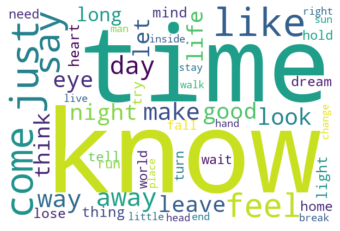

# Topic 2


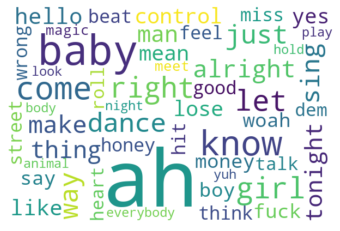

# Topic 3


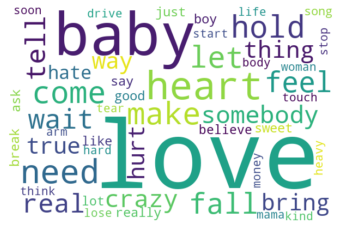

# Topic 4


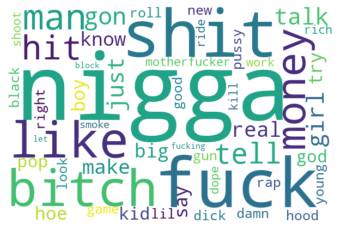

# Topic 5


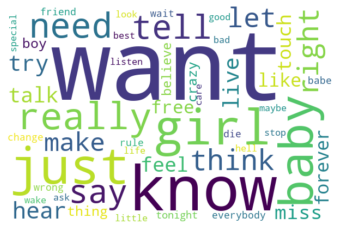

In [ ]:
visualize_topic_top_words(W_topic5, feature_names)

From this we can see some themes emerge. It appears that topic 1 is about life topic 2 is about romantic encounters, topic 3 is about relationships, topic 4 seems to be themes heaily seen in rap and topic 5 seems to be about experiences.

### Looking at 17 topics

First lets take a look at the top words for each topic.

In [ ]:
def extract_topic_top_words(W, all_words, num_top_words=10):
  
    num_words, num_topics = W.shape
    
    assert num_words == len(all_words)
    
    for t in range(0, num_topics):
        top_words_idx = np.argsort(W[:,t])[::-1]  # descending order
        top_words_idx = top_words_idx[:num_top_words]
        top_words = [all_words[k] for k in top_words_idx]
        top_words_shares = W[top_words_idx, t]
        print('# Topic', t+1)
        for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
            print(word, share)
        print('\n')

In [ ]:
extract_topic_top_words(W_topic17, feature_names)

# Topic 1
say 0.8090291622013143
just 0.7016929357884674
try 0.2869187802588493
way 0.2866854543745522
look 0.28213084924924314
like 0.2803792402583799
thing 0.27707498116757706
make 0.21727350065061035
think 0.21559215595545614
little 0.17901673629865605


# Topic 2
ah 3.2424208179292346
sing 0.04871061974157192
right 0.046385015743094886
hello 0.041585526443753115
control 0.038518964218734894
man 0.03527626531357283
alright 0.035061511817501216
dance 0.034027434990356056
tonight 0.033390416757526846
yes 0.03298494927308998


# Topic 3
love 2.5445691286834573
heart 0.1432534721461208
real 0.07696646191475673
fall 0.07407122356199239
bring 0.06029476076138084
somebody 0.059130805644153524
make 0.05840768038234089
hate 0.055167490653932616
true 0.05483098268169905
wait 0.053025476523849965


# Topic 4
nigga 1.409752739549308
fuck 0.5932807727269938
shit 0.5600775194387908
bitch 0.4712827750987744
like 0.3019625253309953
money 0.2887422719058213
hit 0.18071238847278556
man 0.174331513272

The first 5 topics seem to have similar themes when we do 17 topics. 

Nest lets look at how the lyrics correlate.

In [ ]:
num_topics, num_lyrics = H_topic17.shape

H17df = pd.DataFrame(H_topic17, 
                     index=['topic'+str(one) for one in range(1, num_topics+1)], 
                     columns=['lyric'+str(one) for one in range(1, num_lyrics+1)])

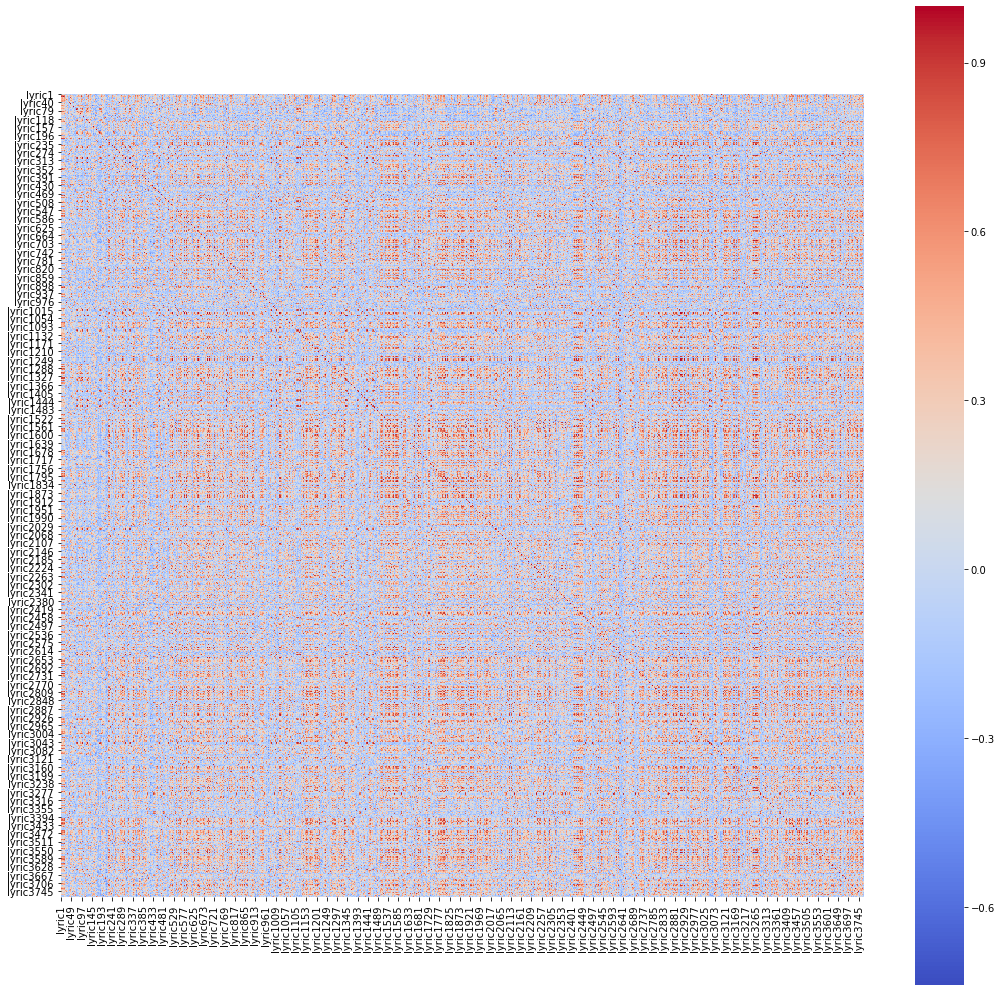

In [ ]:
lyric_corr = H17df.corr()

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,18))
ax = sns.heatmap(lyric_corr, square=True, cmap="coolwarm");

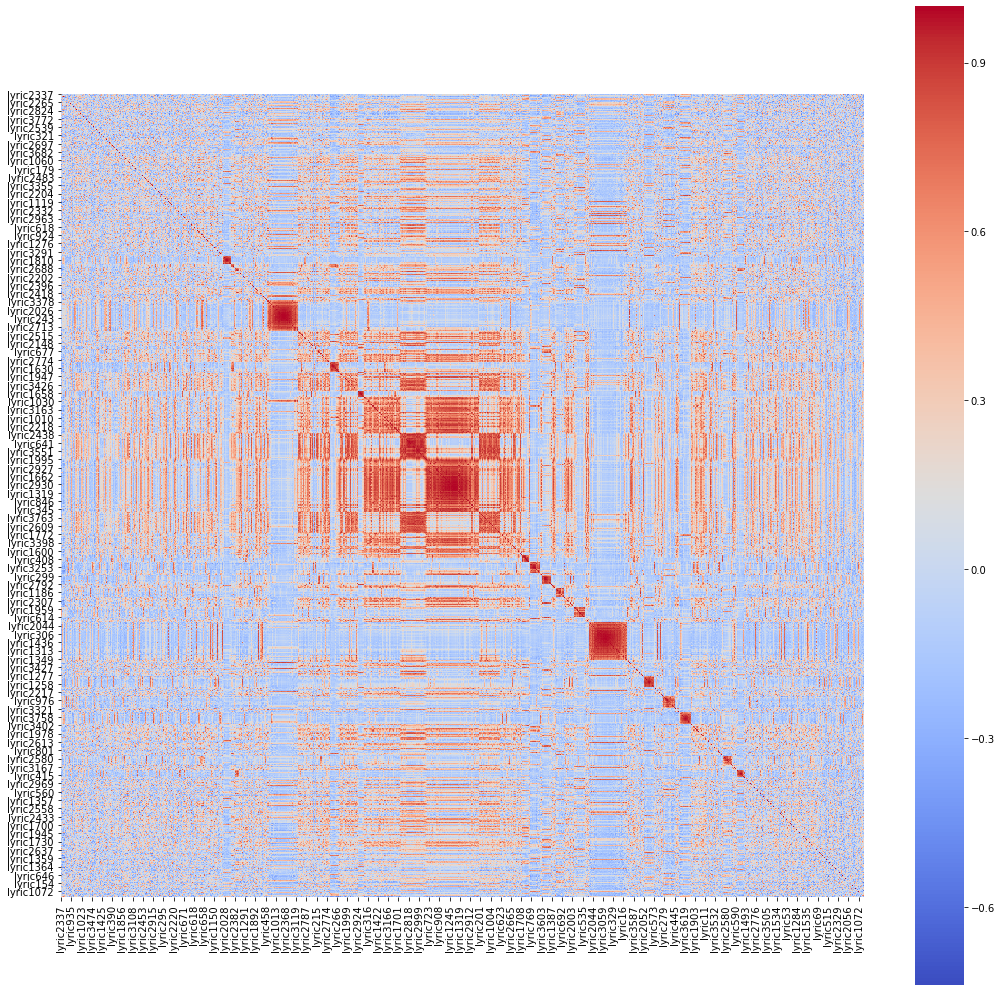

In [ ]:
from scipy.cluster.hierarchy import linkage, leaves_list
lyric_linkage = linkage(lyric_corr.transpose(), optimal_ordering=True)
leave_ord = leaves_list(lyric_linkage)

plt.figure(figsize=(18,18))
sns.heatmap(lyric_corr.iloc[leave_ord, leave_ord], square=True, cmap="coolwarm")



The red squares show us that we do have some strong correlation within certian topics.

### Comparing Topics with Genres 

In order to do this we will look at the coefficient matrix that contains the importance of the topic to each song. Next we compute the topic with the largest importance and add a genre column. We can then apply a group by on the two columns and look at which topics each genre fall under.

In [ ]:
genreTest = H17df.T
genreTest['Max'] = genreTest.max(axis=1)
genreTest['topic'] = genreTest.idxmax(axis=1)
genreTest['genre'] = data['genre'].to_numpy()
GT = genreTest.groupby(['topic','genre']).count().Max
#GT = pd.DataFrame(GT)
data.groupby(['genre']).count().song.to_numpy()

array([ 236,   34,  175,   57,   24,   15,   66,   12,    8,    8,   83,
         69,  374,   50,  590,   23, 1948])

In [ ]:
dcts = {'totals':data.groupby(['genre']).count().song}
for i in range(1,15):
  dcts.update({'topic'+str(i):GT['topic'+str(i)]})
GTtopics = pd.DataFrame(dcts)

for i in range(1,15):
  GTtopics['topic'+str(i)] = GTtopics['topic'+str(i)]/GTtopics['totals']
GTtopics

totals    topic1    topic2  ...   topic12   topic13   topic14
Electronic             236  0.169492  0.059322  ...  0.055085  0.042373  0.042373
Electronic,Pop/R&B      34  0.147059  0.147059  ...       NaN  0.029412       NaN
Electronic,Rock        175  0.154286  0.074286  ...  0.045714  0.062857  0.017143
Experimental            57  0.245614  0.070175  ...  0.035088  0.017544  0.017544
Experimental,Rap        24  0.041667  0.166667  ...       NaN       NaN  0.041667
Experimental,Rock       15  0.133333  0.133333  ...       NaN  0.066667       NaN
Folk/Country            66  0.151515  0.136364  ...  0.060606       NaN  0.015152
Global                  12  0.083333  0.833333  ...       NaN       NaN       NaN
Jazz                     8       NaN  0.500000  ...       NaN       NaN       NaN
Jazz,Metal               8       NaN       NaN  ...       NaN       NaN       NaN
Metal                   83  0.060241  0.012048  ...  0.036145  0.084337       NaN
Metal,Rock              69  0.130435  0.028986  ...  0.057971  0.043478  0.014493
Pop/R&B                374  0.131016  0.125668  ...  0.037433  0.045455  0.032086
Pop/R&B,Rap             50  0.160000  0.040000  ...       NaN       NaN  0.020000
Rap                    590  0.225424  0.044068  ...  0.008475  0.020339  0.020339
Rap,Rock                23  0.347826  0.086957  ...  0.086957       NaN       NaN
Rock                  1948  0.188912  0.063142  ...  0.049281  0.040041  0.039014

[17 rows x 15 columns]

We can see that most of the genres are dispersed amongst many of the topics. This makes a lot of sense, the topics that were generated group the songs by theme but most genres contain multiple themes within them. We can make some interesting observations about the connection amongst genres from this table. For example, if you look at topic 4 it seems to resonate strongly with rap, experimental rap, and pop/R&B/rap. This matches our intuition about those genres connection with each other. A less intuitive connection can be found by looking at the values in topic 3. You can see that the most prevalent genres are jazz and folk/country, a connection that most might not be aware of. 

# Acoustic Features VS Lyrics

Since we have normalized the lyrics, we apply the normalization function to a dataset of songs which are the top quartile of the values highest on 'speechiness', 'energy', 'acousticness'. Energy and acousticness were choosen due to them being the highest (energy) or lowest (acousticness) correlation to speechiness. 

We first gather the top quartile of songs of each feature into individual dataframes.

In [ ]:
sp_data= data.sort_values(by='speechiness', ascending=False)
sp_data= sp_data.iloc[:951]

energy_data= data.sort_values(by='energy', ascending=False)
energy_data= energy_data.iloc[:951]

acoust_data = data.sort_values(by='acousticness', ascending=False)
acoust_data= acoust_data.iloc[:951]

We then apply the normalization function.

In [ ]:
sp_data = sp_data.lyrics.apply(normalize_text)
energy_data= energy_data.lyrics.apply(normalize_text)
acoust_data= acoust_data.lyrics.apply(normalize_text)

Using the same wordcloud method through frequency, we get three word clouds for songs with the highest speechiness, energy, and acousticness.

###Speechiness

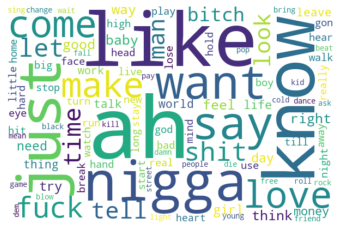

In [ ]:
sp_data_lyrics = '\n'.join(sp_data)
sp_data_lyrics = [word for word in tokenize_text(sp_data_lyrics)]
word_freq_sp = nltk.FreqDist(sp_data_lyrics).most_common(100)

d = {}
for word, freq in word_freq_sp:
    d[word] = freq

wordcloud = WordCloud(height=400, width=600, background_color='White')
wordcloud.generate_from_frequencies(frequencies=d) 
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

###Energy

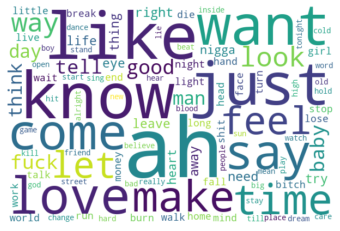

In [ ]:
energy_data_lyrics = '\n'.join(energy_data)
energy_data_lyrics = [word for word in tokenize_text(energy_data_lyrics)]
word_freq_energy = nltk.FreqDist(energy_data_lyrics).most_common(100)

d = {}
for word, freq in word_freq_energy:
    d[word] = freq

wordcloud = WordCloud(height=400, width=600, background_color='White')
wordcloud.generate_from_frequencies(frequencies=d) 
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

###Acousticness

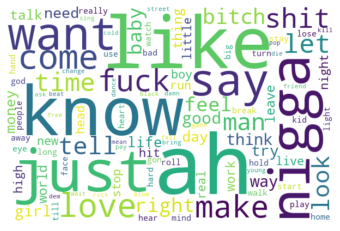

In [ ]:
acoust_data_lyrics = '\n'.join(acoust_data)
acoust_data_lyrics = [word for word in tokenize_text(acoust_data_lyrics)]
word_freq_acoust = nltk.FreqDist(acoust_data_lyrics).most_common(100)

d = {}
for word, freq in word_freq_sp:
    d[word] = freq

wordcloud = WordCloud(height=400, width=600, background_color='White')
wordcloud.generate_from_frequencies(frequencies=d) 
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Conclusion
From the result of our analysis, we can conclude that we cannot split songs into genres solely based on the acoustic features or lyrics. In other words, it suggests that the definition of genre is more complicated than it seems. For instance, rock songs do not always share similar acoustic features or the same topics of lyrics. The variation within a genre appear to be no less than that among different genres. It is difficult to capture the subtleties that distinguish one genre from another. 
One way to improve this could be to take more factors into consideration. We can try to combine the acoustic features and the frequency table generated from words in the lyrics. The song features would need to be standardized and appropriately weighted. Then we can use similar methods like NMF to extract the most significant features and words at the same time. In this way, we might be able to categorize songs into a few groups, each of which is defined by certain features and/or keywords. 
It would also be interesting to explore the connections between topics generated from lyrics and song features. For songs whose lyrics fall into one topic, we can examine whether they have similar acoustic features. We can also build a model that predicts the musical features for a random song based on its lyrics only. 

